In [1]:
import numpy as np

In [25]:
from cvxopt import matrix, solvers

In [524]:
from sklearn import svm
from sklearn import preprocessing
from sklearn import metrics

In [384]:
%matplotlib inline
import matplotlib.pyplot as plt

In [440]:
X,Y = load_CSV('creditCard.csv')
X = preprocessing.scale(X)

In [410]:
linear_svc = svm.SVC(kernel='linear')

In [441]:
np.random.seed(2018)
itrain = np.random.choice(len(X), int(X.shape[0]*0.9),replace=False)
itest = np.array(list(set(range(len(X))) - set(itrain)))

In [517]:
linear_svc.fit(X[itrain],Y[itrain])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [518]:
linear_svc.score(X[itest], Y[itest])

0.84848484848484851

In [465]:
compare = linear_svc.predict(X[itest]) - Y[itest]
len(compare[compare==0]) / len(compare)

0.8484848484848485

In [527]:
X_train = X[itrain]
y_train = Y[itrain]
X_test = X[itest]
y_test = Y[itest]
y_score = linear_svc.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(curve)):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

IndexError: too many indices for array

In [557]:
def ROC(X,Y, classifier):
    scores = classifier.decision_function(X)
    #ROC
    curve = sorted(zip(scores,Y), key=lambda x:x[0])
    x = [0 for i in range(len(curve))]
    y = [0 for i in range(len(curve))]
    for i in range(1,len(curve)):
        if curve[i][1]==1:
            x[i] = x[i-1]
            y[i] = y[i-1]+1/len(Y[Y==1])
        else:
            x[i] = x[i-1]+1/len(Y[Y==0])
            y[i] = y[i-1]  
    plt.plot(x,y)
    plt.xlim(0,1)
    plt.ylim(0,1)
    return x,y

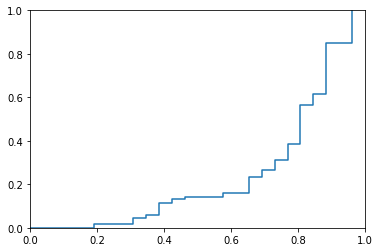

In [558]:
x,y = ROC(X[itest], Y[itest], linear_svc)

In [528]:
def AUC(x,y):
    area = 0
    for i in range(1,len(x)):
        area += (x[i] - x[i-1]) * y[i]
    return area

In [541]:
AUC(x,y)

0.20101596516690842

In [561]:
rbf_svc = svm.SVC(gamma=25)

In [562]:
rbf_svc.fit(X[itrain], Y[itrain])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=25, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

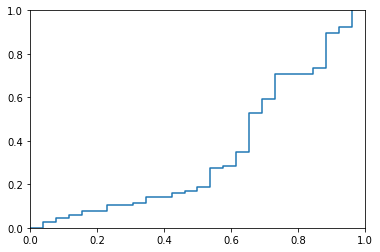

In [563]:
x, y = ROC(X[itest], Y[itest], rbf_svc)

In [564]:
AUC(x,y)

0.3120464441219156

In [188]:
def load_CSV(file_name):
    tmp = np.loadtxt(file_name, dtype=np.str, delimiter=",")
    features = tmp[1:,:-1].astype(np.float)# load features
    labels = tmp[1:,-1].astype(np.float)# load labels
    return features, labels # return ndarray

In [288]:
class SVC():
    def __init__(self, kernel=None, C=0):
        self.C = C
        if kernel == None:
            self.kernel = lambda x,z : np.dot(x,z)
        else:
            self.kernel = kernel
    
    def train(self, X, Y):
        n = len(Y)
        P = matrix([[(self.kernel(X[i],X[j]) * Y[i]*Y[j]) for i in range(n)] for j in range(n)])
        q = matrix([-1. for i in range(n)])
        G = matrix(-np.eye(n))
        h = matrix(np.zeros((n,1)))
        A = matrix(Y).trans()
        b = matrix(0.)
        sol = solvers.qp(P, q, G, h, A, b)
        
        self.w = (np.array(sol['x']) * Y.reshape(-1, 1)).T @ X
        self.b = - ( np.min(X[Y==1] @ w.T) + np.max(X[Y==-1] @ w.T) )/2
        
    def predict(self, X, Y=None):
        '''
        make prediction. If label is given, analyse the model.
        '''
        scores = X @ self.w.T + self.b
        Y_hat = [1 if score>0 else -1 for score in scores]
        
        
        if Y != None: #label is given, do analysis
            #confusion matrix
            TP = 0
            FP = 0
            FN = 0
            TN = 0
            for i in range(len(X)):
                if Y_hat[i]==Y[i]:
                    if Y_hat[i]==1:
                        TP += 1
                    else:
                        TN += 1
                else:
                    if Y_hat[i]==1:
                        FP += 1
                    else:
                        FN += 1
            
            accuracy = (TP + TN)/len(X)
            CM = {
                'TP':TP,
                'FP':FP,
                'FN':FN,
                'TN':TN
                }
            
            #ROC
            curve = sorted(zip(scores,Y), key=lambda x:x[0])
            x = [0 for i in range(len(curve))]
            y = [0 for i in range(len(curve))]
            for i in range(1,len(curve)):
                if curve[i][1]==1:
                    x[i] = x[i-1]
                    y[i] = y[i-1]+1/(TP+FN)
                else:
                    x[i] = x[i-1]+1/(TN+FP)
                    y[i] = y[i-1]  
            plt.plot(x,y)
            plt.xlim(0,1)
            plt.ylim(0,1)
            
            #AUC
            area = 0
            for i in range(1,len(x)):
                area += (x[i] - x[i-1]) * y[i]
            area
            #output
            prediction = {
                        'X':X,
                        'scores':scores,
                        'prediction':Y_hat,
                        'accuracy':accuracy,
                        'confusion matrix':CM,
                        'area under curve':area
                         }
            return prediction
        
        return Y_hat

In [362]:
scores = X @ w.T + b
Y_hat = [1 if score>0 else -1 for score in scores]

In [404]:
TP = 0
FP = 0
FN = 0
TN = 0
for i in range(len(X)):
    if Y_hat[i]==Y[i]:
        if Y_hat[i]==1:
            TP += 1
        else:
            TN += 1
    else:
        if Y_hat[i]==1:
            FP += 1
        else:
            FN += 1

In [406]:
x = [0 for i in range(len(curve))]
y = [0 for i in range(len(curve))]
for i in range(1,len(curve)):
    if curve[i][1]==1:
        x[i] = x[i-1]
        y[i] = y[i-1]+1/(TP+FN)
    else:
        x[i] = x[i-1]+1/(FP+TN)
        y[i] = y[i-1]

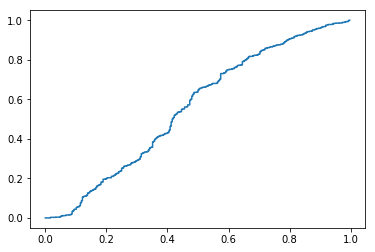

In [407]:
plt.plot(x,y)

In [379]:
curve = sorted(zip(scores,Y), key=lambda x:x[0])
curve

[(array([-0.00579792]), -1.0),
 (array([-0.00419745]), -1.0),
 (array([-0.00416355]), -1.0),
 (array([-0.00411709]), -1.0),
 (array([-0.00403324]), -1.0),
 (array([-0.00398766]), -1.0),
 (array([-0.00378941]), 1.0),
 (array([-0.00378331]), 1.0),
 (array([-0.00370607]), 1.0),
 (array([-0.00369571]), -1.0),
 (array([-0.00364192]), -1.0),
 (array([-0.00363863]), -1.0),
 (array([-0.00361328]), -1.0),
 (array([-0.00359248]), -1.0),
 (array([-0.00355322]), 1.0),
 (array([-0.00353078]), -1.0),
 (array([-0.00352722]), -1.0),
 (array([-0.00349436]), -1.0),
 (array([-0.00336818]), -1.0),
 (array([-0.00334975]), 1.0),
 (array([-0.0033399]), -1.0),
 (array([-0.00332733]), 1.0),
 (array([-0.00327123]), 1.0),
 (array([-0.0032513]), 1.0),
 (array([-0.00322365]), 1.0),
 (array([-0.00321737]), -1.0),
 (array([-0.00318866]), 1.0),
 (array([-0.00315908]), 1.0),
 (array([-0.00315125]), -1.0),
 (array([-0.00314715]), 1.0),
 (array([-0.00314553]), -1.0),
 (array([-0.00314185]), -1.0),
 (array([-0.00313861])

In [364]:
scores,Y

(array([[ -1.52369022e-03],
        [  9.25398686e-05],
        [ -8.87395454e-04],
        ..., 
        [ -1.70713911e-03],
        [  7.33543253e-04],
        [ -1.50634537e-03]]), array([ 1.,  1.,  1., ...,  1.,  1.,  1.]))

In [356]:
scores.sort(0)
scores

array([[-0.00579792],
       [-0.00419745],
       [-0.00416355],
       ..., 
       [ 0.0031525 ],
       [ 0.00325462],
       [ 0.00378941]])

In [315]:
z.__next__()

(array([-0.00152369]), 1.0)

In [296]:
A

<1x1319 matrix, tc='d'>

In [286]:
score.shape

(1319, 1)

In [303]:
mysvc.train(X,Y)

     pcost       dcost       gap    pres   dres
 0: -6.7749e+02 -2.2276e+03  1e+04  1e+02  3e+00
 1: -3.3606e+03 -8.4826e+03  1e+04  9e+01  3e+00
 2: -7.9622e+03 -1.6570e+04  1e+04  7e+01  2e+00
 3: -2.0497e+04 -2.7214e+04  7e+03  5e+01  1e+00
 4: -8.4496e+04 -9.2098e+04  8e+03  4e+01  1e+00
 5: -8.8768e+05 -9.0554e+05  2e+04  4e+01  1e+00
 6: -2.5074e+07 -2.5308e+07  2e+05  4e+01  1e+00
 7: -8.5109e+08 -8.5661e+08  6e+06  4e+01  1e+00
 8: -8.5958e+08 -8.6515e+08  6e+06  4e+01  1e+00
 9: -8.7097e+08 -8.7660e+08  6e+06  4e+01  1e+00
10: -1.0923e+09 -1.0993e+09  7e+06  4e+01  1e+00
11: -1.2861e+09 -1.2942e+09  8e+06  4e+01  1e+00
12: -1.4510e+09 -1.4600e+09  9e+06  4e+01  1e+00
Terminated (singular KKT matrix).


In [298]:
mysvc.train(X,Y)

     pcost       dcost       gap    pres   dres
 0: -6.7749e+02 -2.2276e+03  1e+04  1e+02  3e+00
 1: -3.3606e+03 -8.4826e+03  1e+04  9e+01  3e+00
 2: -7.9622e+03 -1.6570e+04  1e+04  7e+01  2e+00
 3: -2.0497e+04 -2.7214e+04  7e+03  5e+01  1e+00
 4: -8.4496e+04 -9.2098e+04  8e+03  4e+01  1e+00
 5: -8.8768e+05 -9.0554e+05  2e+04  4e+01  1e+00
 6: -2.5074e+07 -2.5308e+07  2e+05  4e+01  1e+00
 7: -8.5109e+08 -8.5661e+08  6e+06  4e+01  1e+00
 8: -8.5958e+08 -8.6515e+08  6e+06  4e+01  1e+00
 9: -8.7097e+08 -8.7660e+08  6e+06  4e+01  1e+00
10: -1.0923e+09 -1.0993e+09  7e+06  4e+01  1e+00
11: -1.2861e+09 -1.2942e+09  8e+06  4e+01  1e+00
12: -1.4510e+09 -1.4600e+09  9e+06  4e+01  1e+00
Terminated (singular KKT matrix).


In [304]:
def radial_basis_kernel(x,z,sigma_sqr):
    return np.exp(- np.linalg.norm(x-z) / sigma_sqr)